## Multi Label Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import datetime
import os
from tensorflow.keras.layers import Input, Dense, concatenate
from tensorflow.keras.models import Model
import pandas as pd 
import numpy as np
import tensorflow as tf
import datetime
import os
from tensorflow.keras.layers import Input, Dense, concatenate, BatchNormalization
from tensorflow.keras.models import Model
import pandas as pd 
import numpy as np
from sklearn.preprocessing import MinMaxScaler


from keras import metrics

In [3]:
## load input data

pad_x = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/second_pad_x.npy')
student_major = pd.read_csv('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/new_student_major.csv')
y = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/second_train_y.npy')

print("pad_x shape : ", pad_x.shape)
print("major shape : ", student_major.shape)
print("y shape : ", y.shape)

pad_x shape :  (21966, 84)
major shape :  (21966, 2)
y shape :  (21966, 133878)


In [4]:
## load embeddings

#image_embedding
image_embeddings = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/image_embedding.npy')
image_embeddings= np.reshape(image_embeddings, (133878, 1280))
min_max_scaler = MinMaxScaler()
image_embeddings = min_max_scaler.fit_transform(image_embeddings)
print("image embedding : ", image_embeddings.shape) #(133878, 1280)

#page-year embedding
page_embeddings = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/page_embeddings.npy')
min_max_scaler = MinMaxScaler()
page_embeddings = min_max_scaler.fit_transform(page_embeddings)
print("page embedding : ", page_embeddings.shape) #(133878, 6)


#BERT genre embedding 
genre_embeddings = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/genre_embeddings(word).npy')
min_max_scaler = MinMaxScaler()
genre_embeddings = min_max_scaler.fit_transform(genre_embeddings)
print("genre embedding : ", genre_embeddings.shape) #(133878, 768)


#bert title embedding 
title_embeddings = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/sentence_embeddings.npy')
min_max_scaler = MinMaxScaler()
title_embeddings = min_max_scaler.fit_transform(title_embeddings)
print("title embedding : ", title_embeddings.shape) #(133878, 768)

#bert MAJOR embedding 
major_embeddings = np.load('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/major_embeddings.npy') #major_embeddings_full_name(with college).npy
min_max_scaler = MinMaxScaler()
major_embeddings = min_max_scaler.fit_transform(major_embeddings)
print("major_embedding : ", major_embeddings.shape) #(22024, 768)

image embedding :  (133878, 1280)
page embedding :  (133878, 6)
genre embedding :  (133878, 768)
title embedding :  (133878, 768)
major_embedding :  (21966, 768)


In [5]:

# from keras.metrics import top_k_categorical_accuracy

# def top_5_categorical_accuracy(y_true, y_pred):
#     return top_k_categorical_accuracy(y_true, y_pred, k=5) 

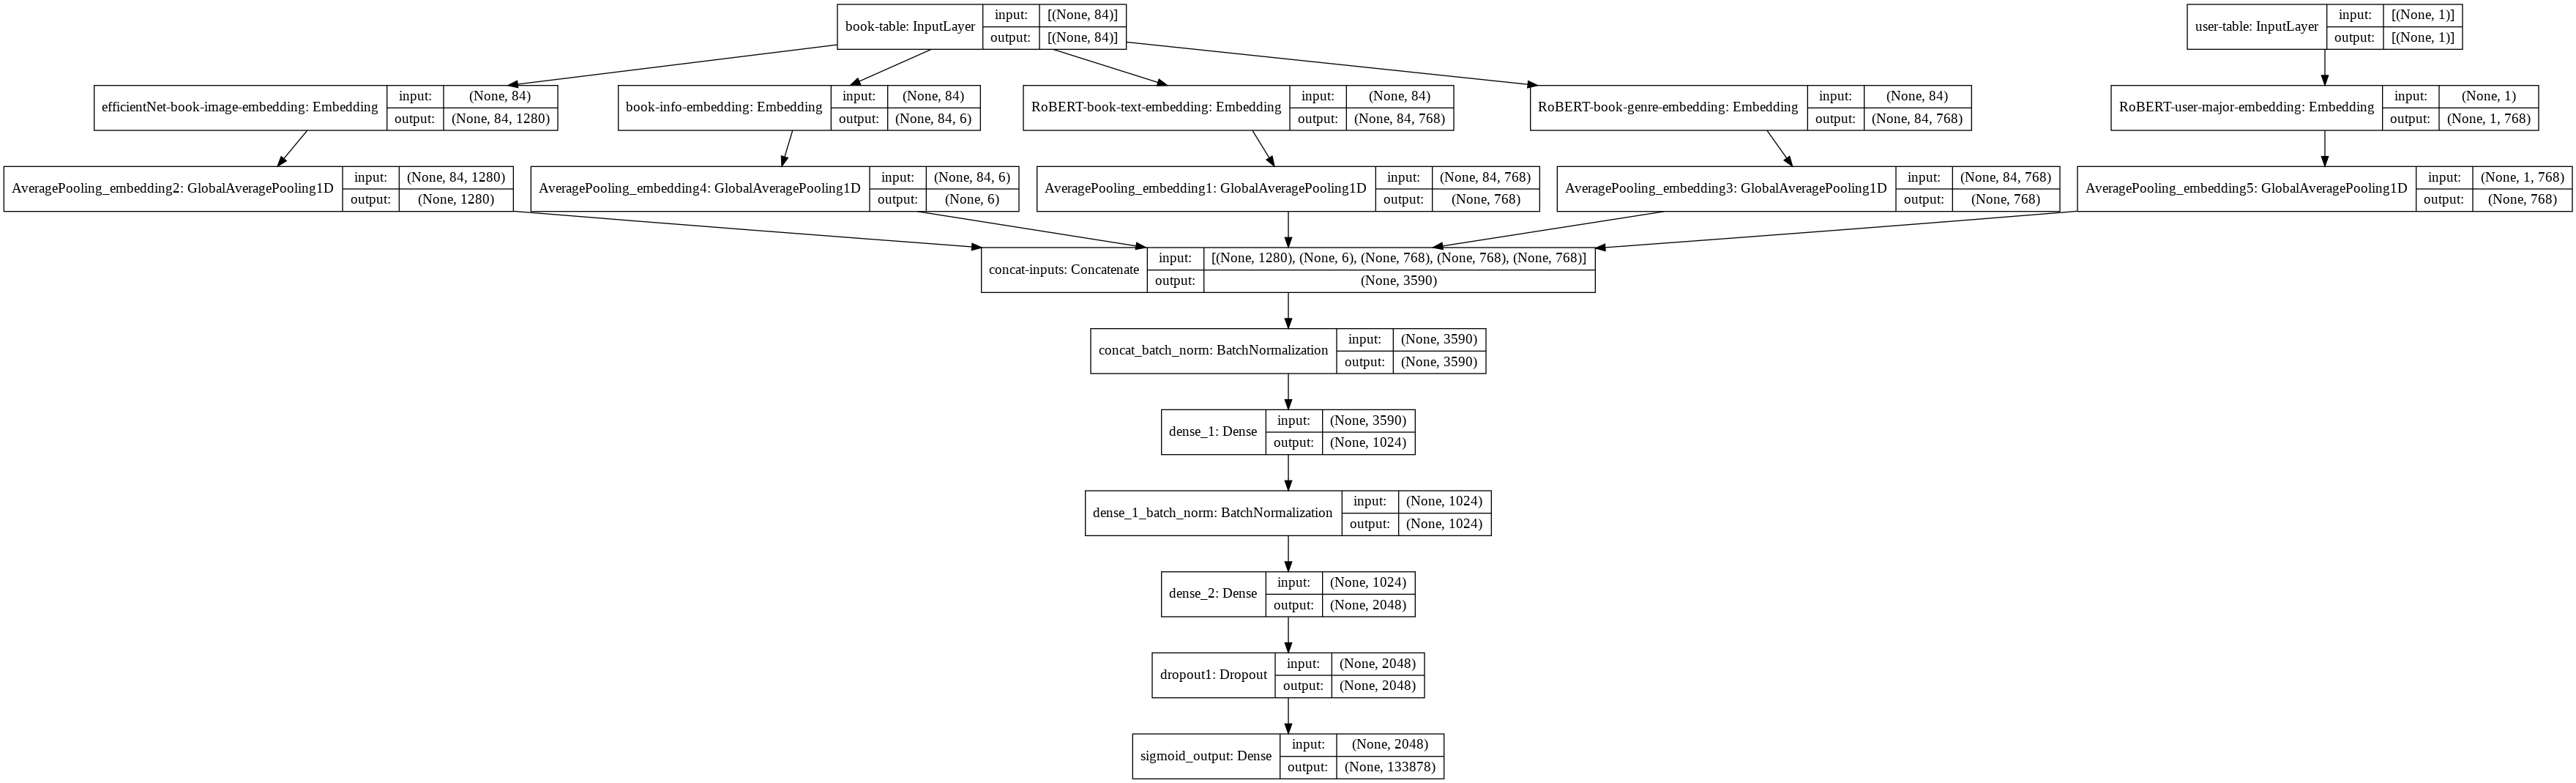

In [6]:
# 랜덤시드 고정시키기
np.random.seed(2021)
tf.random.set_seed(2021)

#basic settings 
LEARNING_RATE = 0.01
DROPOUT_PCT = 0.5
ALPHA = 0.1

student_num = pad_x.shape[0]
book_num = title_embeddings.shape[0]


#INPUT 
max_len = 84
book = tf.keras.Input(shape=(max_len, ), name='book-table') #shape: user,book
user = tf.keras.Input(shape=(1, ), name='user-table') #shape: user,book


#EMBEDDING 
#title 
text_embedding_layer = tf.keras.layers.Embedding(input_dim = title_embeddings.shape[0] ,  #133878
                                                 output_dim = title_embeddings.shape[1], #768,
                                                 input_length = max_len, 
                                                #  mask_zero = True,
                                                 weights = [title_embeddings],
                                                 trainable=True, 
                                                 name = 'RoBERT-book-text-embedding')


#book image 
img_embedding_layer = tf.keras.layers.Embedding(input_dim = image_embeddings.shape[0] ,   #133878
                                                output_dim = image_embeddings.shape[1], #1028,
                                                input_length = max_len, 
                                                # mask_zero = True,
                                                weights = [image_embeddings],
                                                trainable=True, 
                                                name = 'efficientNet-book-image-embedding')


#genre 
book_genre_embeddings = tf.keras.layers.Embedding(input_dim = genre_embeddings.shape[0] , 
                                                  output_dim = genre_embeddings.shape[1], 
                                                  input_length = max_len, 
                                                  # mask_zero = True,
                                                  weights = [genre_embeddings],
                                                  trainable=True, 
                                                  name = 'RoBERT-book-genre-embedding')


#LOOK-UP TABLE 
#book_age(pub year) &  page 
book_info_embeddings = tf.keras.layers.Embedding(input_dim = page_embeddings.shape[0] , 
                                                 output_dim = page_embeddings.shape[1], 
                                                 input_length = max_len, 
                                                #  mask_zero = True,
                                                 weights = [page_embeddings],
                                                 trainable=True, 
                                                 name = 'book-info-embedding')

#major 
user_info_layer = tf.keras.layers.Embedding(input_dim = major_embeddings.shape[0] ,  #22024
                                            output_dim = major_embeddings.shape[1],  #768
                                            input_length = 1, 
                                            # mask_zero = True,
                                            weights = [major_embeddings],
                                            trainable=True, 
                                            name = 'RoBERT-user-major-embedding')



#DENSE LAYER 
dense_1 = tf.keras.layers.Dense(units = 1024, activation = 'relu', name = 'dense_1',kernel_initializer = 'he_uniform')
dense_2 = tf.keras.layers.Dense(units = 2048, activation = 'tanh', name = 'dense_2',kernel_initializer = 'he_uniform')

dense_output = tf.keras.layers.Dense(page_embeddings.shape[0], activation = 'sigmoid', name = 'sigmoid_output')
dropout_1= tf.keras.layers.Dropout(DROPOUT_PCT, name = 'dropout1')


#EMBEDDINGS 
text_embeddings = text_embedding_layer(book)
title= tf.keras.layers.GlobalAveragePooling1D(name = 'AveragePooling_embedding1')(text_embeddings)

img_embeddings = img_embedding_layer(book)
image = tf.keras.layers.GlobalAveragePooling1D(name = 'AveragePooling_embedding2')(img_embeddings)

genre_embeddings = book_genre_embeddings(book)
genre= tf.keras.layers.GlobalAveragePooling1D(name = 'AveragePooling_embedding3')(genre_embeddings)

info_embeddings = book_info_embeddings(book)
info= tf.keras.layers.GlobalAveragePooling1D(name = 'AveragePooling_embedding4')(info_embeddings)

user_info_embeddings = user_info_layer(user)
major= tf.keras.layers.GlobalAveragePooling1D(name = 'AveragePooling_embedding5')(user_info_embeddings)



#BUILD MODEL 

#CONCAT : title, genre, major
concat_inputs = tf.keras.layers.Concatenate(axis = 1, name = 'concat-inputs')([image, info, title, genre, major])
concat_inputs = tf.keras.layers.BatchNormalization(name = 'concat_batch_norm')(concat_inputs)


#DENSE 
dense_1_features = dense_1(concat_inputs)
dense_1_batch_norm = tf.keras.layers.BatchNormalization(name='dense_1_batch_norm')(dense_1_features)
dense_1_relu = dense_1_batch_norm

dense_2_features = dense_2(dense_1_relu)
dense_2_relu = dense_2_features
dense_2_dropout = dropout_1(dense_2_relu)

outputs = dense_output(dense_2_dropout)



#Optimizer
# optimizer = tf.keras.optimizers.AdaGrad(learning_rate = LEARNING_RATE)
# optimizer= tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, name='SGD')
# optimizer= tf.keras.optimizers.SGD(learning_rate = LEARNING_RATE, momentum = 0.8, name = 'SGD')

# optimizer= tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE, name = 'adam')
optimizer= tf.keras.optimizers.RMSprop(learning_rate= LEARNING_RATE , name = 'RMSprop')


model = tf.keras.models.Model(inputs = [book, user], outputs = [outputs])



model.compile(optimizer = optimizer,
              loss = tf.keras.losses.BinaryCrossentropy(), # loss = tf.nn.weighted_cross_entropy_with_logits( 'labels', 'logits',  'pos_weight'),
              metrics = ['categorical_accuracy']) #tf.keras.metrics.top_k_categorical_accuracy() top__categorical_accuracy



# VISUALIZATION 
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True,dpi=96)

In [7]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
book-table (InputLayer)         [(None, 84)]         0                                            
__________________________________________________________________________________________________
user-table (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
efficientNet-book-image-embeddi (None, 84, 1280)     171363840   book-table[0][0]                 
__________________________________________________________________________________________________
book-info-embedding (Embedding) (None, 84, 6)        803268      book-table[0][0]                 
______________________________________________________________________________________________

In [ ]:
history = model.fit([pad_x, student_major['major']], y, epochs = 250, batch_size = 64)

Epoch 1/250
344/344 [==============================] - 257s 737ms/step - loss: 0.5835 - categorical_accuracy: 5.2432e-04
Epoch 2/250
344/344 [==============================] - 250s 727ms/step - loss: 2.8171e-04 - categorical_accuracy: 3.6034e-04
Epoch 3/250
344/344 [==============================] - 251s 728ms/step - loss: 2.7741e-04 - categorical_accuracy: 3.8968e-04
Epoch 4/250
344/344 [==============================] - 251s 730ms/step - loss: 2.5828e-04 - categorical_accuracy: 0.0011
Epoch 5/250
344/344 [==============================] - 251s 731ms/step - loss: 2.6909e-04 - categorical_accuracy: 4.9384e-04
Epoch 6/250
344/344 [==============================] - 251s 731ms/step - loss: 2.6169e-04 - categorical_accuracy: 5.8602e-04
Epoch 7/250
344/344 [==============================] - 251s 728ms/step - loss: 2.7176e-04 - categorical_accuracy: 5.2525e-04
Epoch 8/250
344/344 [==============================] - 256s 745ms/step - loss: 2.6963e-04 - categorical_accuracy: 8.4072e-04
Epoch 9/

In [ ]:
# model.save("[0121]svg_momemtum_0.8.h5")
model.save('[0124]RMSprop_0.01.h5')

In [ ]:
model.save('/content/drive/MyDrive/명륜이네 서재/DL_FINAL/model2/[0124]RMSprop_0.01.h5')